In [60]:
%matplotlib inline
from yahoo_finance import Share
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from datetime import date, timedelta
from sklearn import linear_model
from pylab import *
from optparse import OptionParser
from pylab import *
from os.path import expanduser
home = expanduser("~")

import os

os.system('cls' if os.name == 'nt' else 'clear');

/Users/kkim/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [29]:
endDay =365*8
startDay = 1
startDate = date.today()-timedelta(days=endDay)
endDate = date.today()-timedelta(days=startDay)
# print (startDate, endDate)
# # 60 weeks from startDate
# dates = pd.date_range(startDate, periods=60)
# print(dates)


In [30]:
import quandl
goldHistory = quandl.get("LBMA/GOLD")
goldHistory = pd.DataFrame(goldHistory['USD (PM)'])

In [31]:
def cdf(dev_divided_by_std):
    return (1.0 + math.erf(dev_divided_by_std / sqrt(2.0))) / 2.0

In [33]:
uup = Share('UUP')
uupHistory_raw = uup.get_historical(str(startDate), str(endDate))

In [34]:
datestrs = [startDate]*(len(uupHistory_raw))
pricestrs_uup = [0.0]*(len(uupHistory_raw))

for i in range(len(uupHistory_raw)):
    datestrs[i] = uupHistory_raw[i]['Date']
    pricestrs_uup[i] = float(uupHistory_raw[i]['Close'])

pricestrs_uup = [0.0]*(len(uupHistory_raw))
for i in range(len(uupHistory_raw)):
    pricestrs_uup[i] = float(uupHistory_raw[i]['Close'])

uupHistory = pd.DataFrame(pd.Series(pricestrs_uup, index = datestrs))

uupHistory.index = pd.to_datetime(uupHistory.index)
goldHistory.index = pd.to_datetime(goldHistory.index)
uupHistory = uupHistory.rename(columns={0: "uup"})
goldHistory = goldHistory.rename(columns={'USD (PM)': "gold"})

df = pd.DataFrame()
df = pd.concat([uupHistory, goldHistory], axis=1, join='inner')

df = df[np.isnan(df.gold)==False]

mult = df.gold * df.uup
df['multiplication'] = mult

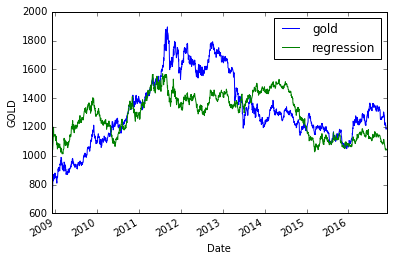

In [41]:
model = linear_model.LinearRegression()

X= np.array(df.uup)
X_= np.array([np.ones(len(X)), X, X**2]).T
model.fit(X_, 1/np.array(df.gold))
model.coef_
X_=np.matrix(X_)
#plt.plot(X_*np.matrix(model.coef_).T, 1/np.array(df.uup))
#plt.show()
gold_fit = np.array(1/model.predict(X_))

df['regression'] = pd.Series(gold_fit, index = df.index)

dev = df.gold-df['regression']
stdev = sqrt(mean(dev**2))
alpha = dev/stdev
df['alpha'] = pd.Series(alpha, index = df.index)

df.sort_index(inplace=True)
figure(num=1, figsize=(6,6))
# df[['gold', 'fit']].plot()
df[['gold', 'regression']][0:2000].plot()
plt.ylabel("GOLD")
plt.xlabel("Date")
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
#savefig(home+'/html/python/img/GOLD.png', bbox_inches='tight')
savefig('figures/GOLD.png', bbox_inches='tight')

In [59]:
plt.ylabel("GOLD")
plt.xlabel("UUP (Dollar Value)")
plt.plot(df['gold'], df['uup'])

NameError: name 'plt' is not defined

### NUGT vs. UUP 

In [61]:
df1 = pd.read_csv('http://chartapi.finance.yahoo.com/instrument/1.0/nugt/chartdata;type=quote;range=5d/csv',
               skiprows=22, names = ['timestamp','close', 'high', 'low', 'open', 'volume'])
df2 = pd.read_csv('http://chartapi.finance.yahoo.com/instrument/1.0/uup/chartdata;type=quote;range=5d/csv',
               skiprows=22, names = ['timestamp','close', 'high', 'low', 'open', 'volume'])

#df
import datetime
df1['time'] = df1['timestamp'].apply(datetime.datetime.fromtimestamp)
df2['time'] = df2['timestamp'].apply(datetime.datetime.fromtimestamp)

In [84]:
df = pd.DataFrame()
minlength = min(len(df1), len(df2))
df['uup'] = df2['close'][0:minlength]
df['nugt'] = df1['close'][0:minlength]
df = df.set_index(df1['time'][0:minlength])

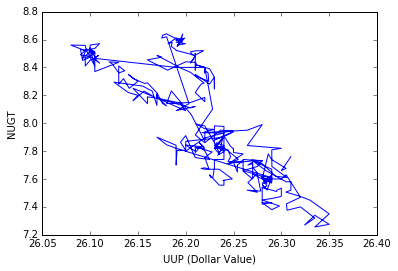

In [86]:
plt.ylabel("NUGT")
plt.xlabel("UUP (Dollar Value)")
plt.plot(df['uup'][0:350], df['nugt'][0:350])

In [ ]:
# %load uwti.py
from yahoo_finance import Share
import matplotlib
matplotlib.use('Agg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from datetime import date, timedelta
from sklearn import linear_model
from pylab import *
from optparse import OptionParser
from pylab import *
from os.path import expanduser
from pandas.tseries.offsets import BDay
import os
import datetime, threading, time
from pandas.tseries.offsets import BDay
import json

home = expanduser("~")
os.system('cls' if os.name == 'nt' else 'clear')

# Linear regression: y = a0 + a1 x, where y = 1/wti and x = uup (dollar value)
model = linear_model.LinearRegression()

########################################################################################
# Trading strategy
# 1. Momentum
# 2. uwti price vs. dollar value (training for 3 days) --> linear regression.
# 3. uwti price vs. dollar value (cross validation for 2 days) by using the linear model.
########################################################################################

# Slope from 3 day training data.
def compute_slope(df):
    y = np.array(df.uwti)
    x = np.array(range(0,len(df)))[:,np.newaxis]
    model.fit(x, y)
    return [model.coef_[0], model.intercept_]

########################################################################################
# 1. Momentum
########################################################################################

# If the slope is positive and large enough, then "consider" trading for the next two days.
def trading_condition(df):
    slope=compute_slope(df)[0]
    intercept = compute_slope(df)[1]
    #print slope

    sigma = np.std(df.uwti - 1/(intercept + slope * df.uup))
    #print sigma
    #if slope > 0:
    if slope > sigma/len(df):
        return True
    else:
        return False




# cumulative distribution function -- probability that the uwti stock price can increase.
# probability = alpha < 0.5 -- uwti is overestimated and likely goes down for the next few days.
# probability = alpha > 0.5 -- uwti is underestimated and likely increases for the next few days.
def cdf(dev_divided_by_std):
    return (1.0 + math.erf(dev_divided_by_std / sqrt(2.0))) / 2.0



def execute_trading(df, dfcv):

    ########################################################################################
    # 2. uwti price vs. dollar value (training for 3 days) --> linear regression.
    ########################################################################################

    #training set = df
    X = np.array(df.uup)
    X_= np.array([np.ones(len(X)), X]).T

    #cross validation set = dfcv
    Xcv = np.array(dfcv.uup)
    Xcv_ = np.array([np.ones(len(Xcv)),Xcv]).T

    #linear regression
    model.fit(X_, 1/np.array(df.uwti))
    model.coef_

    #standard deviation is computed from the training set and will be used to compute alpha.
    X_ = np.matrix(X_)
    uwti_fit = np.array(1/model.predict(X_))
    df['regression'] = pd.Series(uwti_fit, index = df.index)
    dev = df.uwti-df.regression
    stdev = sqrt(mean(dev**2))

    ########################################################################################
    # 3. uwti price vs. dollar value (cross validation for 2 days) by using the linear model.
    ########################################################################################

    Xcv_ = np.matrix(Xcv_)
    uwti_fit = np.array(1/model.predict(Xcv_))
    dfcv['prediction'] = pd.Series(uwti_fit, index = dfcv.index)
    dfcv['regression'] = dfcv['prediction']

    #print 'here'
    df_all = df[['uup', 'uwti', 'regression']].append(dfcv[['uup', 'uwti', 'regression']])
    #print 'here2'

    dev = dfcv.uwti-dfcv.prediction
    alpha = dev/stdev
    short_pos = cdf(alpha)*100


    value_b = 0.0
    date_b = None

    if short_pos < 10:
        bought = True
        value_b = dfcv.uwti
        date_b = dfcv.index
        #print "UWTI value: $%f    Date: %s" % (value_b, str(date_b))

    if model.intercept_ > 0:
        return [True, alpha, value_b, str(date_b), df_all]
    else:
        return [False, alpha, None, None, df_all]



# Retrieve real-time stock prices
# Data pre-processing
# Panda dataframe (df): main data file
startDate = date.today()-timedelta(days=10)
endDate = date.today()

uwti = Share('UWTI')
uup = Share('UUP')
uwtiHistory_raw = uwti.get_historical(str(startDate), str(endDate))
uupHistory_raw = uup.get_historical(str(startDate), str(endDate))

datestrs = [startDate]*(len(uwtiHistory_raw))
pricestrs_uwti = [0.0]*(len(uwtiHistory_raw))

for i in range(len(uwtiHistory_raw)):
    datestrs[i] = pd.to_datetime(uwtiHistory_raw[i]['Date'])
    pricestrs_uwti[i] = float(uwtiHistory_raw[i]['Close'])

pricestrs_uup = [0.0]*(len(uwtiHistory_raw))
for i in range(len(uupHistory_raw)):
    pricestrs_uup[i] = float(uupHistory_raw[i]['Close'])

uwtiHistory = pd.Series(pricestrs_uwti, index = datestrs)
uupHistory = pd.Series(pricestrs_uup, index = datestrs)

df = pd.DataFrame({'uwti':pricestrs_uwti, 'uup':pricestrs_uup}, index = datestrs)
df.sort_index(inplace=True)
df = df[-4:] # stock price data for the last 4 days were used as training data.


###############################################################################
# Linear regression: y = a0 + a1 x, where y = 1/uwti and x = uup (dollar value)
###############################################################################

executed = False
trainingPeriod = 4 # training period = last 4 days (closing price)

df.sort_index(inplace=True)
########################################
def foo():
# commented out for demo.
    time_out = time.time() + 3600*20
    while True:
        # Trading suggestion based on the current uwti and uup and the previous 5 days data (regression).
        #if time.time() > time_out:
        #    break

        if trading_condition(df[['uup', 'uwti']][0:trainingPeriod]):
            uwti = Share('UWTI')
            uup = Share('UUP')

            uwti_now = float(uwti.get_price())
            uup_now = float(uup.get_price())
            df_now = pd.DataFrame.copy(pd.DataFrame(data = {'uwti':uwti_now, 'uup':uup_now}, index = [pd.to_datetime(uwti.get_trade_datetime())]))
            [executed, alpha, value, today_datetime, df_all] = execute_trading(df[['uup', 'uwti']][0:trainingPeriod], df_now)
            with open('/var/www/html/python/img/momentum.json', 'wb') as outfile:
                if executed:
                    #print "momentum and the inverse relationship between uup and uwti is good enough for trading."
                    json.dump("PASSED", outfile)
                else:
                    json.dump("FAILED", outfile)
            font = {'weight' : 'bold', 'size'   : 14}
            matplotlib.rc('font', **font)
            ax = df_all[['uwti', 'regression']].plot(marker='o', linestyle='--')
            ax.set_ylabel("UWTI", fontsize=20)
            ax.set_xlabel("Date", fontsize=20)
            plt.fill_between(pd.to_datetime(df_all.index[0:4]),1.3, 2.0, facecolor='green', alpha=0.1)
            savefig('/var/www/html/python/img/UWTI.png', bbox_inches='tight')
            plt.show()

            # UWTI short and long pos probabilities (%)
            short_pos = cdf(alpha)*100
            long_pos = 100-short_pos

            #print short_pos, long_pos

            prob = {"cols":[{"label":"Position","type":"string"}, {"label":"Probability","type":"number"}],
                    "rows":[{"c":[{"v": "Short"}, {"v":short_pos}]},{"c":[{"v": "Long"}, {"v":long_pos}]}]
            }
            with open('/var/www/html/python/img/uwti.json', 'wb') as outfile:
                json.dump(prob, outfile)

            # DWTI short and long pos probabilities (%)
            prob = {
                "cols":[{"label":"Position","type":"string"}, {"label":"Probability","type":"number"}],
                "rows":[{"c":[{"v": "Short"}, {"v": long_pos}]}, {"c":[{"v": "Long"}, {"v": short_pos}]}]
            }
            with open('/var/www/html/python/img/dwti.json', 'wb') as outfile:
                json.dump(prob, outfile)
            #clf()

            #uwti_analysis_now = { str(datetime.datetime.now()):{"Price":uwti_now, "Regression":float(regression_now)}}
            uwti_analysis_now = {"Price":uwti_now}
            with open('/var/www/html/python/img/uwti_analysis_now.json', 'wb') as outfile:
                json.dump(uwti_analysis_now, outfile)

            with open('/var/www/html/python/img/estimation.json', 'wb') as outfile:
                if short_pos < 10:
                    #print "momentum and the inverse relationship between uup and uwti is good enough for trading."
                    json.dump("PASSED", outfile)
                else:
                    json.dump("FAILED", outfile)
        print "alpha, short_pos: %f, %f" % (alpha, short_pos)
        time.sleep(180)


timerThread = threading.Thread(target=foo)
timerThread.start()


#########################
## google chart pie plots
#########################
# font = {'weight' : 'bold',
#         'size'   : 22}
# matplotlib.rc('font', **font)
# fig2 = figure(num=2, figsize=(6,6))
#
# stock = ('DWTI','UWTI')
# r = len(stock)
# ax = axes([0.1, 0.1, 0.8, 0.8])
#
# labels = 'Short', 'Long'
# fracs = [short_pos, long_pos]
# explode=(0, 0.05)
# pie(fracs, explode=explode, labels=labels, autopct='%1.0f%%', shadow=True, startangle=90,
#     colors = cm.Set1([0.2,0.5]))
# title('UWTI')
# savefig('/var/www/html/python/img/UWTI_prob.png', bbox_inches='tight')
# #clf()


# # make a square figure and axes
# plt.figure(num=3, figsize=(6,6))
# ax = axes([0.1, 0.1, 0.8, 0.8])
# font = {
#         'weight' : 'bold',
#         'size'   : 22}
# matplotlib.rc('font', **font)
# labels = 'Short', 'Long'
# fracs = [long_pos, short_pos]
# explode=(0, 0.05)
# pie(fracs, explode=explode, labels=labels, autopct='%1.0f%%', shadow=True, startangle=90,
#     colors = cm.Set1([0.2,0.5]))
# title('DWTI')
# savefig('/var/www/html/python/img/DWTI_prob.png', bbox_inches='tight')
#clf()